### Imports

In [44]:
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet50_Weights, ResNet34_Weights, ResNet18_Weights, AlexNet_Weights
import torchvision.transforms as T
from torch.nn.utils import weight_norm as wn
from scipy import stats
import cv2 as cv
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print('imported')

imported


### Constants

In [45]:
data_path = './data/'
class_list = os.listdir(data_path)
print('Number of classes: {}'.format(len(class_list)))

# working device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Selected device: {}'.format(device))

# other cosntants
MAX_SEQ_LEN = 1
BATCH_SIZE = 4
EPOCHS = 100
IMG_SIZE = (350, 350)
NUM_CHANNELS = 3

Number of classes: 38
Selected device: cuda:0


### Data preprocessing

In [46]:
# some stats about the data
mean, median, mode = np.zeros(3)
sequences = []
targets = []

class_dict = dict([(j, i) for i, j in enumerate(class_list)])

for class_name in class_dict.keys():
    repetitions_list = os.listdir(data_path + class_name)
    sequences.extend(
        [data_path + class_name + '/' + rep + '/' for rep in repetitions_list]
    )
    targets.extend([class_dict[class_name]] * len(repetitions_list))
    
sequences_stats = [len(os.listdir(seq)) for seq in sequences]

sequences = np.array(sequences)
targets = np.array(targets)

mean = np.mean(sequences_stats)
median = np.median(sequences_stats)
mode = stats.mode(sequences_stats)

print('For a total of {} sequences'.format(len(sequences)))
print('Mean: {:.2f}'.format(mean))
print('Median: {:.2f}'.format(median))
print('Mode: {}'.format(mode))
print('Min: {}'.format(min(sequences_stats)))
print('Max: {}'.format(max(sequences_stats)))

train_sequences, test_sequences, train_targets, test_targets = train_test_split(
    sequences, targets, test_size=0.1, random_state=42
)


print('Number of train sequences: {}'.format(len(train_sequences)))
print('Number of test sequences: {}'.format(len(test_sequences)))

print('Number of train sequences combinations by {} images length: {}'.format(
    MAX_SEQ_LEN, np.sum([len(os.listdir(seq)) - MAX_SEQ_LEN for seq in train_sequences])
))
print('Number of test sequences combinations by {} images length: {}'.format(
    MAX_SEQ_LEN, np.sum([len(os.listdir(seq)) - MAX_SEQ_LEN for seq in test_sequences])
))


For a total of 364 sequences
Mean: 38.99
Median: 37.00
Mode: ModeResult(mode=array([55]), count=array([132]))
Min: 15
Max: 55
Number of train sequences: 327
Number of test sequences: 37
Number of train sequences combinations by 1 images length: 12420
Number of test sequences combinations by 1 images length: 1410


In [26]:
class PlantDataset(torch.utils.data.Dataset):
    def __init__(self, files, targets, max_sequence_len, transform=T.ToTensor()):
        super(PlantDataset, self).__init__()
        self.files = files
        self.targets = targets
        self.max_sequence_len = max_sequence_len
        self.transform = transform
        
    def __len__(self):
        return self.files.__len__()

    def __getitem__(self, idx):
        sequence_target = self.targets[idx]
        sequence_files = os.listdir(self.files[idx])
        # we assume file names can be sorted. Otherwise, change this code
        sequence_files.sort()

        sequence = np.empty((self.max_sequence_len, NUM_CHANNELS, *IMG_SIZE))

        img_idx = 0
        start_index = np.random.randint(0, len(sequence_files) - self.max_sequence_len + 1)
        for i in range(start_index, start_index + self.max_sequence_len):
            img = cv.imread(self.files[idx] + sequence_files[i])
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, IMG_SIZE)
            if self.transform:
                img = self.transform(img)
            sequence[img_idx] = img
            img_idx += 1
        
        if self.max_sequence_len == 1:
            sequence = sequence[0]

        return sequence, sequence_target

## Just an example

Sample shape: (3, 350, 350)
Class: Ede-1


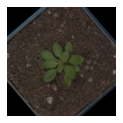

In [47]:
train_dataset = PlantDataset(train_sequences, train_targets, max_sequence_len=MAX_SEQ_LEN, transform=T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomRotation([90, 270]),
    T.ToTensor()
]))
sample, target = train_dataset[np.random.randint(0, len(train_dataset))]
print('Sample shape: {}'.format(sample.shape))

if len(sample.shape) == 3:
    sample = np.expand_dims(sample, 0)

plt.figure(figsize=(5 * MAX_SEQ_LEN, 2 * MAX_SEQ_LEN))
for i in range(MAX_SEQ_LEN):
    plt.subplot(1, MAX_SEQ_LEN, i + 1)
    plt.imshow((sample[i].transpose(1, 2, 0) * 255).astype(np.uint8))
    plt.axis('off')    
print('Class: {}'.format(class_list[target]))
plt.show()


### Defining the model

In [82]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.cnn = torchvision.models.alexnet(weights=AlexNet_Weights.DEFAULT)
        self.cnn.classifier[-1] = nn.Linear(self.cnn.classifier[-1].in_features, num_classes)

        for name, module in self.cnn.named_modules():
            if 'features' in name:
                for param in module.parameters():
                    param.requires_grad = False
        
    def forward(self, x):
        x = self.cnn(x)
        return x

class ConvRecurrentNetwork(nn.Module):
    def __init__(self, num_classes=2, backbone='resnet18', img_embed=300, lstm_embed=256, lstm_layers=3, dropout=0.2):
        super(ConvRecurrentNetwork, self).__init__()
        self.img_embed = img_embed
        self.lstm_embed = lstm_embed
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        # CNN part
        if backbone == 'resnet18':
            self.cnn = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        elif backbone == 'resnet34':
            self.cnn = torchvision.models.resnet34(weights=ResNet34_Weights.DEFAULT)
        elif backbone == 'resnet50':
            self.cnn = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        elif backbone == 'alexnet':
            self.cnn = torchvision.models.alexnet(weights=AlexNet_Weights.DEFAULT)

        self.cnn.fc = nn.Sequential(
            nn.Linear(self.cnn.fc.in_features, img_embed),
            nn.BatchNorm1d(img_embed),
        )
        
        # LSTM part
        self.lstm = nn.LSTM(input_size=img_embed, hidden_size=lstm_embed, num_layers=lstm_layers, bidirectional=False, 
            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(lstm_embed, lstm_embed // 2)
        self.fc2 = nn.Linear(lstm_embed // 2, num_classes)

        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
       
    def forward(self, x):
        assert x.shape.__len__() == 5, 'Input shape must be 5 dimensional (Batch, Sequence, Channel, Height, Width)'
        # this resnet is invariant to image size since it's using AverageGlobalPool2d
        batch_size, img_size = x.shape[0], x.shape[2:]
        x = x.reshape(-1, *img_size)
        x = self.cnn(x)
        x = x.reshape(batch_size, -1, self.img_embed)

        # lstm
        h_0 = torch.autograd.Variable(torch.zeros(self.lstm_layers, x.size(0), self.lstm_embed)).to(device)
        c_0 = torch.autograd.Variable(torch.zeros(self.lstm_layers, x.size(0), self.lstm_embed)).to(device)
        x, (h_n, c_n) = self.lstm(x, (h_0, c_0))      

        x = h_n[-1, :, :].squeeze(0)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Training the model

In [85]:
# loading data
train_dataset = PlantDataset(train_sequences, train_targets, max_sequence_len=1, transform=T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomRotation([90, 270]),
    T.ToTensor()
]))
val_dataset = PlantDataset(test_sequences, test_targets, max_sequence_len=1, transform=T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomRotation([90, 270]),
    T.ToTensor()
]))

# data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


# defining model
# training the CNN
crnn = ConvNet(num_classes=len(class_list)).to(device)

#crnn = ConvRecurrentNetwork(
#    num_classes=len(class_list), backbone='resnet18', img_embed=126, lstm_embed=126, dropout=0.1, lstm_layers=1
#).to(device)
# crnn = RecurrentCNN(embed_dim=128, hidden_size=256, num_layers=3, num_classes=len(class_list)).to(device)
# crnn = ResNet50(num_classes=len(class_list), dropout=0.2).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(crnn.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-6)

train_loss_history = list()
train_acc_history = list()
val_loss_history = list()
val_acc_history = list()

for epoch in range(EPOCHS):
    for phase in ['train', 'eval']:
        if phase == 'train':
            crnn.train()
            dataloader = train_loader
        else:
            crnn.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0
        total = 0

        progress = tqdm(dataloader)
        for i, (sequences, targets) in enumerate(dataloader):
            sequences, targets = sequences.to(device, dtype=torch.float), torch.Tensor(targets).to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = torch.nn.functional.log_softmax(crnn(sequences), dim=1)
                loss = criterion(outputs, targets.long())
                _, preds = torch.max(outputs, 1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            total += targets.size(0)
            running_corrects += torch.sum(preds == targets)

            with torch.no_grad():
                progress.update(1)
                progress.set_description('Epoch: {}/{} - Phase: {:6} - Loss: {:.4f} - Acc: {:.2f}%'.format(
                    epoch + 1, EPOCHS, phase, running_loss / (i + 1), (running_corrects.double() / total) * 100
                ))

        epoch_loss = running_loss / dataloader.__len__()
        epoch_acc = running_corrects.double() / total
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        progress.close()
        del progress


Epoch: 1/100 - Phase: train  - Loss: 3.8028 - Acc: 2.38%:  26%|██▌       | 21/81 [01:25<04:04,  4.08s/it]
Epoch: 1/100 - Phase: train  - Loss: 3.8333 - Acc: 2.47%: 100%|██████████| 81/81 [00:15<00:00,  5.22it/s]
Epoch: 1/100 - Phase: eval   - Loss: 3.6461 - Acc: 0.00%: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s]
Epoch: 2/100 - Phase: train  - Loss: 3.5749 - Acc: 3.40%: 100%|██████████| 81/81 [00:17<00:00,  4.75it/s]
Epoch: 2/100 - Phase: eval   - Loss: 3.6180 - Acc: 5.56%: 100%|██████████| 9/9 [00:01<00:00,  5.35it/s]
Epoch: 3/100 - Phase: train  - Loss: 3.5038 - Acc: 6.79%: 100%|██████████| 81/81 [00:17<00:00,  4.74it/s] 
Epoch: 3/100 - Phase: eval   - Loss: 3.5044 - Acc: 13.89%: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]
Epoch: 4/100 - Phase: train  - Loss: 3.4786 - Acc: 4.32%: 100%|██████████| 81/81 [00:20<00:00,  3.97it/s]
Epoch: 4/100 - Phase: eval   - Loss: 3.4906 - Acc: 8.33%: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s] 
Epoch: 5/100 - Phase: train  - Loss: 3.4125 - Acc: 

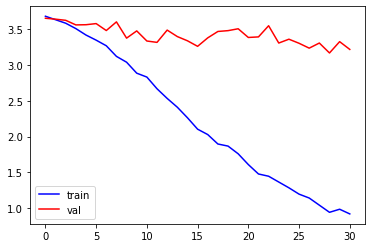

In [30]:
plt.plot(train_loss_history, label='train', color='blue')
plt.plot(val_loss_history, label='val', color='red')
plt.legend()
plt.show()

In [90]:
test_imgs, test_targ = [], []
for i, rep in enumerate(test_sequences):
    files = os.listdir(rep)
    for file in files:
        test_imgs.append(rep + '/' + file)
        test_targ.append(test_targets[i])

imgs = torch.empty(len(test_imgs), 3, 224, 224)
for i, img_file in enumerate(tqdm(test_imgs)):
    img = cv.imread(img_file)
    img = cv.resize(img, (224, 224))
    img = torchvision.transforms.ToTensor()(img)
    imgs[i] = img


100%|██████████| 1514/1514 [00:13<00:00, 112.16it/s]


In [98]:
rcnn.eval()
correct = 0
for i, img in enumerate(tqdm(imgs)):
    img = img.unsqueeze(0).to(device)
    outputs = torch.nn.functional.log_softmax(rcnn(img), dim=1)
    _, preds = torch.max(outputs, 1)
    if preds == test_targ[i]:
        correct += 1

acc = correct / imgs.size(0)
print('Accuracy: {:.4f}'.format(acc))


100%|██████████| 1514/1514 [00:44<00:00, 34.10it/s]

Accuracy: 0.5707


In [ ]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

class MNISTSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len=5, transform=None):
        self.data = data
        self.transform = transform
        self.seq_len = seq_len
    
    def __len__(self):
        return self.data.__len__()

    def __getitem__(self, index):
        _, target = self.data[index]
        sequence = np.zeros((5, 1, 28, 28))
        same_class = 


        if self.transform:
            img = self.transform(img)
        return img, label

## Evaluating the model

In [46]:
eval_dataset = PlantDataset(data_path, max_sequence_len=5, transform=None)
eval_loader = torch.utils.data.DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True
)

rcnn.eval()
with torch.no_grad():
    total, correct = 0, 0
    for data in eval_loader:
        sequences, targets = data
        sequences, targets = sequences.to(device, dtype=torch.float), torch.Tensor(targets).to(device)
        output = torch.nn.functional.log_softmax(rcnn(sequences))
        _, predicted = torch.max(output.data, dim=1)
        loss_value = criterion(output, targets)
        loss_am.append(loss_value.item())
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    print('Accuracy of the network : %d %%' % (100 * correct / total))
    print('Loss: {:.4f}'.format(np.mean(loss_am)))
        

Total number of classes: 40
Total number of sequences: 371


c:\Users\madia\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Accuracy of the network : 98 %
Loss: 0.3230


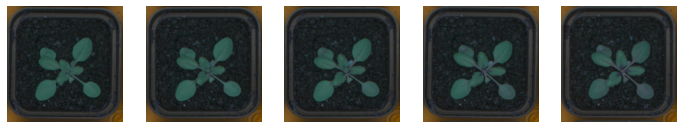

Target index: 11
Corresponding class: Ei-6
Path to image: ./data/Ei-6/rep_09/
Predicted index: tensor(11, device='cuda:0')
Corresponding class: Ei-6


In [64]:
index = np.random.randint(0, dataset.__len__())
sequence, target = dataset[index]

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow((sequence[i].transpose(1, 2, 0) * 255).astype(np.uint8))
    plt.axis('off')
plt.show()

print('Target index:', target)
print('Corresponding class:', class_list[target])
print('Path to image:', dataset.sequences[index])

# inference
rcnn.eval()
with torch.no_grad():
    sequence, target = torch.tensor(sequence).to(device, dtype=torch.float), torch.tensor(target).to(device)
    output = torch.nn.functional.log_softmax(rcnn(sequence.unsqueeze(0)), dim=0)
    _, predicted = torch.max(output.data, dim=0)
    print('Predicted index:', predicted)
    print('Corresponding class:', class_list[predicted])